# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
# !unzip processed-celeba-small.zip

In [2]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import (
    Compose,
    ToTensor,
    Resize,
    Normalize,
    RandomHorizontalFlip,
    RandomRotation,
)

import tests

In [3]:
data_dir = "processed_celeba_small/celeba/"

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [4]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """Transforms to apply to the image."""
    # First resize the image to the desired size, next flip the image horizontally, then apply random rotation.
    # Finally, the image is converted to a tensor and normalized to have values in the range [-1, 1].
    transforms = [
        Resize(size),
        RandomHorizontalFlip(0.5),
        RandomRotation(10),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]

    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [5]:
import os


class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """

    def __init__(
        self,
        directory: str,
        transforms: Callable = None,
        extension: str = ".jpg",
    ):
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        self.image_paths = glob(os.path.join(directory, "*" + extension))

    def __len__(self) -> int:
        """returns the number of items in the dataset"""
        return len(self.image_paths)

    def __getitem__(self, index: int) -> torch.Tensor:
        """load an image and apply transformation"""
        # return the index-element of the dataset
        return self.transforms(Image.open(self.image_paths[index]))

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

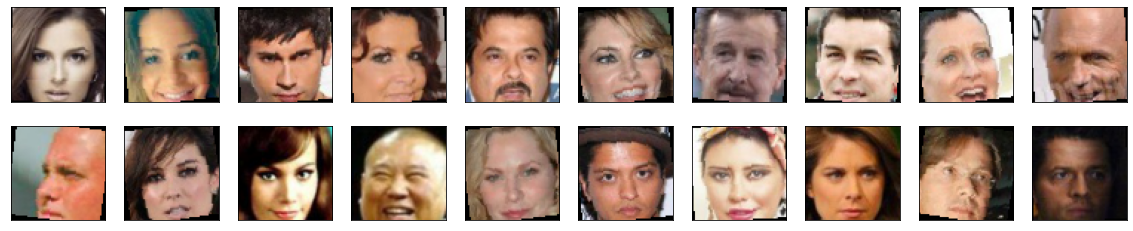

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""


def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.0) / 2.0 * 255).astype(np.uint8)


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size / 2), idx + 1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [8]:
from torch import nn

In [9]:
class ConvBlock(nn.Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        batch_norm: bool = True,
    ):
        super(ConvBlock, self).__init__()

        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=2,
            padding=1,
            bias=False,
        )
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [10]:
class Discriminator(nn.Module):
    """
    The discriminator model adapted from the DCGAN paper. It should only contains a few layers.
    args:
    - conv_dim: control the number of filters
    """

    def __init__(self, conv_dim: int = 64):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 64x64 input
        self.conv1 = ConvBlock(
            3, conv_dim, 4, batch_norm=False
        )  # first layer, no batch_norm
        # 32x32 input
        self.conv2 = ConvBlock(conv_dim, conv_dim * 2, 4)
        # 16x16 out
        self.conv3 = ConvBlock(conv_dim * 2, conv_dim * 4, 4)
        # 8x8 out
        self.conv4 = ConvBlock(conv_dim * 4, conv_dim * 8, 4)
        # 4x4 out

        self.flatten = nn.Flatten()
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim * 8 * 4 * 4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten
        x = self.flatten(x)
        # final output layer
        x = self.fc(x)
        return x

In [11]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [12]:
class DeconvBlock(nn.Module):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
        batch_norm: bool = True,
    ):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size, stride, padding, bias=False
        )
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [13]:
class Generator(nn.Module):
    """
    The generator model adapted from DCGAN
    args:
    - latent_dim: dimension of the latent vector
    - conv_dim: control the number of filters in the convtranspose layers
    """

    def __init__(self, latent_dim: int, conv_dim: int = 64):
        super(Generator, self).__init__()
        # transpose conv layers
        self.deconv1 = DeconvBlock(latent_dim, conv_dim * 8, 4, 1, 0)
        self.deconv2 = DeconvBlock(conv_dim * 8, conv_dim * 4, 4, 2, 1)
        self.deconv3 = DeconvBlock(conv_dim * 4, conv_dim * 2, 4, 2, 1)
        self.deconv4 = DeconvBlock(conv_dim * 2, conv_dim, 4, 2, 1)
        self.deconv5 = nn.ConvTranspose2d(conv_dim, 3, 4, 2, 1)
        self.last_activation = nn.Tanh()

    def forward(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        x = self.last_activation(x)
        return x

In [14]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [15]:
import torch.optim as optim


def create_optimizers(
    generator: nn.Module,
    discriminator: nn.Module,
    lr: float = 0.0002,
    beta1: float = 0.5,
    beta2: float = 0.999,
):
    """This function should return the optimizers of the generator and the discriminator"""
    d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    g_optimizer = optim.Adam(generator.parameters(), lr, [beta1, beta2])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

In [16]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)  # real labels = 1
    # move labels to GPU if available
    if torch.cuda.is_available():
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)  # fake labels = 0
    if torch.cuda.is_available():
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [17]:
def generator_loss(fake_logits):
    """Generator loss, takes the fake scores as inputs."""
    loss = real_loss(fake_logits)
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [18]:
def discriminator_loss(real_logits, fake_logits):
    """Discriminator loss, takes the fake and real logits as inputs."""
    loss = real_loss(real_logits) + fake_loss(fake_logits)
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [19]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """This function enforces"""
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [20]:
def generator_step(
    batch_size: int,
    latent_dim: int,
    discriminator: torch.nn.Module,
    generator: torch.nn.Module,
    g_optimizer: torch.optim.Optimizer,
) -> Dict:
    """One training step of the generator."""
    g_optimizer.zero_grad()

    # 1. Train with fake images and flipped labels

    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    if torch.cuda.is_available():
        z = z.cuda()
    fake_images = generator(z)

    # Compute the discriminator losses on fake images
    # using flipped labels!
    D_fake = discriminator(fake_images)
    g_loss = generator_loss(D_fake)  # use real loss to flip labels

    # perform backprop
    g_loss.backward()
    g_optimizer.step()
    return {"loss": g_loss}


def discriminator_step(
    batch_size: int,
    latent_dim: int,
    real_images: torch.Tensor,
    discriminator: torch.nn.Module,
    generator: torch.nn.Module,
    d_optimizer: torch.optim.Optimizer,
) -> Dict:
    """One training step of the discriminator."""
    d_optimizer.zero_grad()

    # 1. Train with real images

    # Compute the discriminator losses on real images
    if torch.cuda.is_available():
        real_images = real_images.cuda()

    D_real = discriminator(real_images)

    # 2. Train with fake images

    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    # move x to GPU, if available
    if torch.cuda.is_available():
        z = z.cuda()
    fake_images = generator(z)

    # Compute the discriminator losses on fake images
    D_fake = discriminator(fake_images.detach())

    # add up loss and perform backprop
    d_loss = discriminator_loss(D_real, D_fake)
    d_loss.backward()
    d_optimizer.step()
    return {
        "loss": d_loss,
        "gp": gradient_penalty(discriminator, real_images, fake_images),
    }

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [21]:
from datetime import datetime

In [22]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = "cuda"

# number of epochs to train your model
n_epochs = 20

# number of images in each batch
batch_size = 64

# learning rate for optimizers
lr = 0.0002

# beta hyperparam for Adam optimizers
beta1 = 0.5
beta2 = 0.999

In [23]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(
    generator, discriminator, lr, beta1, beta2
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=False,
)

In [24]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""


def display(fixed_latent_vector: torch.Tensor):
    """helper function to display images during training"""
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(
            2, int(plot_size / 2), idx + 1, xticks=[], yticks=[]
        )
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2023-08-07 23:41:09 | Epoch [1/20] | Batch 0/509 | d_loss: 1.3412 | g_loss: 0.1277
2023-08-07 23:41:20 | Epoch [1/20] | Batch 50/509 | d_loss: 1.9122 | g_loss: 0.7325
2023-08-07 23:41:30 | Epoch [1/20] | Batch 100/509 | d_loss: 1.7245 | g_loss: 0.7908
2023-08-07 23:41:41 | Epoch [1/20] | Batch 150/509 | d_loss: 1.6144 | g_loss: 0.8731
2023-08-07 23:41:52 | Epoch [1/20] | Batch 200/509 | d_loss: 1.3286 | g_loss: 0.8268
2023-08-07 23:42:04 | Epoch [1/20] | Batch 250/509 | d_loss: 1.4602 | g_loss: 0.8315
2023-08-07 23:42:15 | Epoch [1/20] | Batch 300/509 | d_loss: 1.3892 | g_loss: 0.8058
2023-08-07 23:42:26 | Epoch [1/20] | Batch 350/509 | d_loss: 1.4268 | g_loss: 0.8373
2023-08-07 23:42:37 | Epoch [1/20] | Batch 400/509 | d_loss: 1.4507 | g_loss: 0.7859
2023-08-07 23:42:48 | Epoch [1/20] | Batch 450/509 | d_loss: 1.4085 | g_loss: 0.6455
2023-08-07 23:42:59 | Epoch [1/20] | Batch 500/509 | d_loss: 1.3272 | g_loss: 0.8240


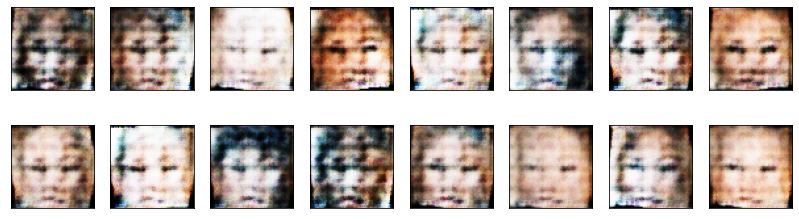

2023-08-07 23:43:05 | Epoch [2/20] | Batch 0/509 | d_loss: 1.3522 | g_loss: 0.8050
2023-08-07 23:43:14 | Epoch [2/20] | Batch 50/509 | d_loss: 1.4057 | g_loss: 0.7264
2023-08-07 23:43:23 | Epoch [2/20] | Batch 100/509 | d_loss: 1.3908 | g_loss: 1.2228
2023-08-07 23:43:32 | Epoch [2/20] | Batch 150/509 | d_loss: 1.5302 | g_loss: 1.6702
2023-08-07 23:43:41 | Epoch [2/20] | Batch 200/509 | d_loss: 1.4662 | g_loss: 0.9338
2023-08-07 23:43:50 | Epoch [2/20] | Batch 250/509 | d_loss: 1.2613 | g_loss: 1.3778
2023-08-07 23:43:59 | Epoch [2/20] | Batch 300/509 | d_loss: 1.1656 | g_loss: 0.9092
2023-08-07 23:44:08 | Epoch [2/20] | Batch 350/509 | d_loss: 1.2589 | g_loss: 0.9025
2023-08-07 23:44:17 | Epoch [2/20] | Batch 400/509 | d_loss: 1.1645 | g_loss: 1.2158
2023-08-07 23:44:26 | Epoch [2/20] | Batch 450/509 | d_loss: 1.3430 | g_loss: 1.7391
2023-08-07 23:44:35 | Epoch [2/20] | Batch 500/509 | d_loss: 1.2426 | g_loss: 1.6898


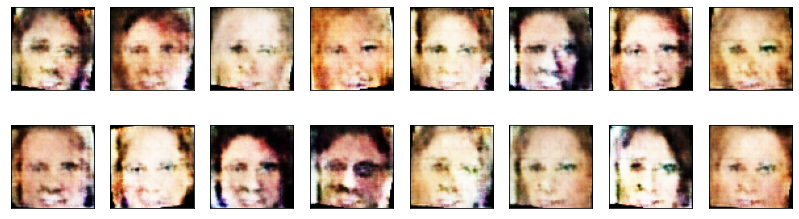

2023-08-07 23:44:40 | Epoch [3/20] | Batch 0/509 | d_loss: 1.2712 | g_loss: 1.3769
2023-08-07 23:44:51 | Epoch [3/20] | Batch 50/509 | d_loss: 1.4877 | g_loss: 0.5506
2023-08-07 23:45:03 | Epoch [3/20] | Batch 100/509 | d_loss: 1.3153 | g_loss: 0.7854
2023-08-07 23:45:14 | Epoch [3/20] | Batch 150/509 | d_loss: 1.4082 | g_loss: 0.8683
2023-08-07 23:45:26 | Epoch [3/20] | Batch 200/509 | d_loss: 1.4844 | g_loss: 0.7057
2023-08-07 23:45:37 | Epoch [3/20] | Batch 250/509 | d_loss: 1.4938 | g_loss: 0.8589
2023-08-07 23:45:48 | Epoch [3/20] | Batch 300/509 | d_loss: 1.4517 | g_loss: 0.7411
2023-08-07 23:46:00 | Epoch [3/20] | Batch 350/509 | d_loss: 1.3557 | g_loss: 0.8269
2023-08-07 23:46:11 | Epoch [3/20] | Batch 400/509 | d_loss: 1.3685 | g_loss: 0.7556
2023-08-07 23:46:33 | Epoch [3/20] | Batch 500/509 | d_loss: 1.3521 | g_loss: 0.7323


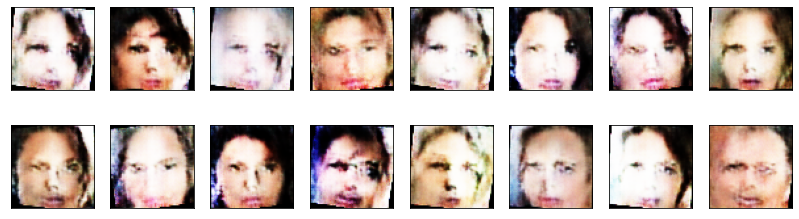

2023-08-07 23:46:40 | Epoch [4/20] | Batch 0/509 | d_loss: 1.3590 | g_loss: 0.8071
2023-08-07 23:46:51 | Epoch [4/20] | Batch 50/509 | d_loss: 1.4156 | g_loss: 0.7479
2023-08-07 23:47:02 | Epoch [4/20] | Batch 100/509 | d_loss: 1.4260 | g_loss: 0.8180
2023-08-07 23:47:14 | Epoch [4/20] | Batch 150/509 | d_loss: 1.3839 | g_loss: 0.8043
2023-08-07 23:47:25 | Epoch [4/20] | Batch 200/509 | d_loss: 1.3548 | g_loss: 0.8380
2023-08-07 23:47:37 | Epoch [4/20] | Batch 250/509 | d_loss: 1.3673 | g_loss: 0.7292
2023-08-07 23:47:48 | Epoch [4/20] | Batch 300/509 | d_loss: 1.4477 | g_loss: 0.7027
2023-08-07 23:47:59 | Epoch [4/20] | Batch 350/509 | d_loss: 1.3661 | g_loss: 0.7319
2023-08-07 23:48:11 | Epoch [4/20] | Batch 400/509 | d_loss: 1.4356 | g_loss: 0.6976
2023-08-07 23:48:22 | Epoch [4/20] | Batch 450/509 | d_loss: 1.3443 | g_loss: 0.6213
2023-08-07 23:48:33 | Epoch [4/20] | Batch 500/509 | d_loss: 1.4911 | g_loss: 0.7280


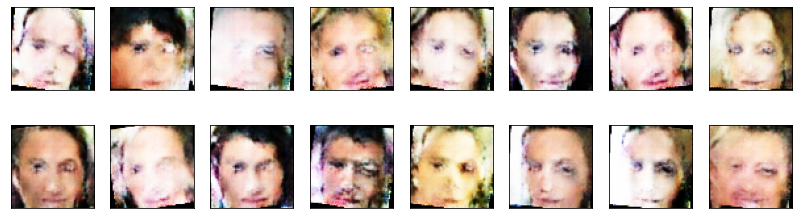

2023-08-07 23:48:38 | Epoch [5/20] | Batch 0/509 | d_loss: 1.3586 | g_loss: 0.7990
2023-08-07 23:48:47 | Epoch [5/20] | Batch 50/509 | d_loss: 1.3933 | g_loss: 0.8128
2023-08-07 23:48:56 | Epoch [5/20] | Batch 100/509 | d_loss: 1.3794 | g_loss: 0.5891
2023-08-07 23:49:06 | Epoch [5/20] | Batch 150/509 | d_loss: 1.3225 | g_loss: 0.7651
2023-08-07 23:49:15 | Epoch [5/20] | Batch 200/509 | d_loss: 1.2788 | g_loss: 0.8722
2023-08-07 23:49:24 | Epoch [5/20] | Batch 250/509 | d_loss: 1.3321 | g_loss: 1.1332
2023-08-07 23:49:32 | Epoch [5/20] | Batch 300/509 | d_loss: 1.3577 | g_loss: 0.6925
2023-08-07 23:49:41 | Epoch [5/20] | Batch 350/509 | d_loss: 1.4226 | g_loss: 1.1292
2023-08-07 23:49:50 | Epoch [5/20] | Batch 400/509 | d_loss: 1.2245 | g_loss: 0.8846
2023-08-07 23:49:59 | Epoch [5/20] | Batch 450/509 | d_loss: 1.4475 | g_loss: 0.8839
2023-08-07 23:50:08 | Epoch [5/20] | Batch 500/509 | d_loss: 1.3442 | g_loss: 1.0366


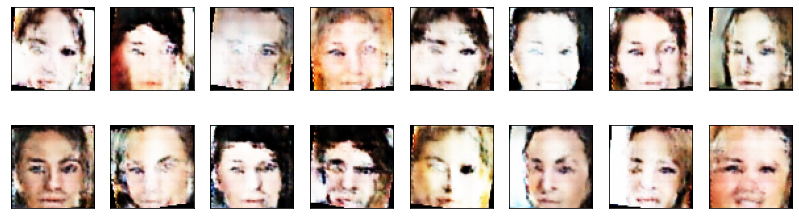

2023-08-07 23:50:14 | Epoch [6/20] | Batch 0/509 | d_loss: 1.3355 | g_loss: 1.0096
2023-08-07 23:50:25 | Epoch [6/20] | Batch 50/509 | d_loss: 1.3701 | g_loss: 0.9560
2023-08-07 23:50:37 | Epoch [6/20] | Batch 100/509 | d_loss: 1.3593 | g_loss: 0.7728
2023-08-07 23:50:48 | Epoch [6/20] | Batch 150/509 | d_loss: 1.4102 | g_loss: 0.8957
2023-08-07 23:50:59 | Epoch [6/20] | Batch 200/509 | d_loss: 1.3595 | g_loss: 0.8318
2023-08-07 23:51:22 | Epoch [6/20] | Batch 300/509 | d_loss: 1.2784 | g_loss: 0.7827
2023-08-07 23:51:33 | Epoch [6/20] | Batch 350/509 | d_loss: 1.4138 | g_loss: 1.0423
2023-08-07 23:51:44 | Epoch [6/20] | Batch 400/509 | d_loss: 1.3412 | g_loss: 0.8368
2023-08-07 23:51:55 | Epoch [6/20] | Batch 450/509 | d_loss: 1.4236 | g_loss: 0.9755
2023-08-07 23:52:06 | Epoch [6/20] | Batch 500/509 | d_loss: 1.3930 | g_loss: 0.7876


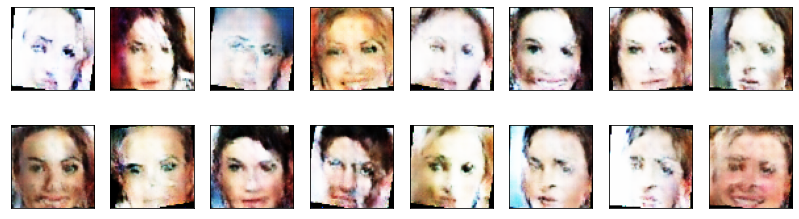

2023-08-07 23:52:13 | Epoch [7/20] | Batch 0/509 | d_loss: 1.3804 | g_loss: 0.7192
2023-08-07 23:52:24 | Epoch [7/20] | Batch 50/509 | d_loss: 1.4087 | g_loss: 0.8262
2023-08-07 23:52:35 | Epoch [7/20] | Batch 100/509 | d_loss: 1.6717 | g_loss: 0.5331
2023-08-07 23:52:46 | Epoch [7/20] | Batch 150/509 | d_loss: 1.3578 | g_loss: 0.6888
2023-08-07 23:52:57 | Epoch [7/20] | Batch 200/509 | d_loss: 1.3764 | g_loss: 0.6975
2023-08-07 23:53:08 | Epoch [7/20] | Batch 250/509 | d_loss: 1.3647 | g_loss: 0.4837
2023-08-07 23:53:20 | Epoch [7/20] | Batch 300/509 | d_loss: 1.3293 | g_loss: 0.8176
2023-08-07 23:53:31 | Epoch [7/20] | Batch 350/509 | d_loss: 1.5000 | g_loss: 1.0351
2023-08-07 23:53:42 | Epoch [7/20] | Batch 400/509 | d_loss: 1.3497 | g_loss: 0.6306
2023-08-07 23:53:53 | Epoch [7/20] | Batch 450/509 | d_loss: 1.2587 | g_loss: 0.8010
2023-08-07 23:54:04 | Epoch [7/20] | Batch 500/509 | d_loss: 1.2694 | g_loss: 0.6436


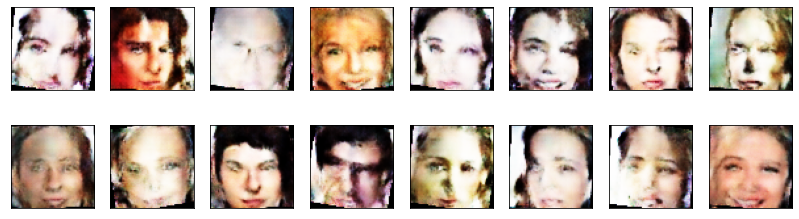

2023-08-07 23:54:11 | Epoch [8/20] | Batch 0/509 | d_loss: 1.3365 | g_loss: 0.7709
2023-08-07 23:54:19 | Epoch [8/20] | Batch 50/509 | d_loss: 1.3193 | g_loss: 1.3317
2023-08-07 23:54:28 | Epoch [8/20] | Batch 100/509 | d_loss: 1.2129 | g_loss: 0.5944
2023-08-07 23:54:37 | Epoch [8/20] | Batch 150/509 | d_loss: 1.2250 | g_loss: 0.7924
2023-08-07 23:54:46 | Epoch [8/20] | Batch 200/509 | d_loss: 1.3716 | g_loss: 1.2736
2023-08-07 23:54:55 | Epoch [8/20] | Batch 250/509 | d_loss: 1.1485 | g_loss: 1.0110
2023-08-07 23:55:04 | Epoch [8/20] | Batch 300/509 | d_loss: 1.2295 | g_loss: 0.7567
2023-08-07 23:55:13 | Epoch [8/20] | Batch 350/509 | d_loss: 1.1717 | g_loss: 0.8660
2023-08-07 23:55:21 | Epoch [8/20] | Batch 400/509 | d_loss: 1.5167 | g_loss: 1.5296
2023-08-07 23:55:30 | Epoch [8/20] | Batch 450/509 | d_loss: 1.3496 | g_loss: 0.7475
2023-08-07 23:55:39 | Epoch [8/20] | Batch 500/509 | d_loss: 1.3009 | g_loss: 0.6258


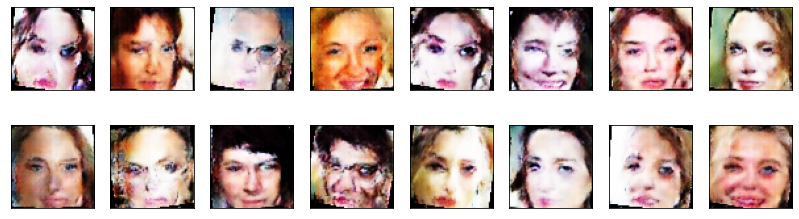

2023-08-07 23:55:45 | Epoch [9/20] | Batch 0/509 | d_loss: 1.3182 | g_loss: 0.2447
2023-08-07 23:55:56 | Epoch [9/20] | Batch 50/509 | d_loss: 1.2578 | g_loss: 1.6297
2023-08-07 23:56:08 | Epoch [9/20] | Batch 100/509 | d_loss: 1.3361 | g_loss: 0.5723
2023-08-07 23:56:19 | Epoch [9/20] | Batch 150/509 | d_loss: 1.2839 | g_loss: 1.7224
2023-08-07 23:56:30 | Epoch [9/20] | Batch 200/509 | d_loss: 1.1547 | g_loss: 1.0565
2023-08-07 23:56:41 | Epoch [9/20] | Batch 250/509 | d_loss: 1.1437 | g_loss: 1.6613
2023-08-07 23:56:52 | Epoch [9/20] | Batch 300/509 | d_loss: 1.0932 | g_loss: 0.9597
2023-08-07 23:57:03 | Epoch [9/20] | Batch 350/509 | d_loss: 1.2111 | g_loss: 0.7880
2023-08-07 23:57:14 | Epoch [9/20] | Batch 400/509 | d_loss: 1.2460 | g_loss: 0.7468
2023-08-07 23:57:25 | Epoch [9/20] | Batch 450/509 | d_loss: 1.2520 | g_loss: 0.6834
2023-08-07 23:57:36 | Epoch [9/20] | Batch 500/509 | d_loss: 1.1545 | g_loss: 1.1314


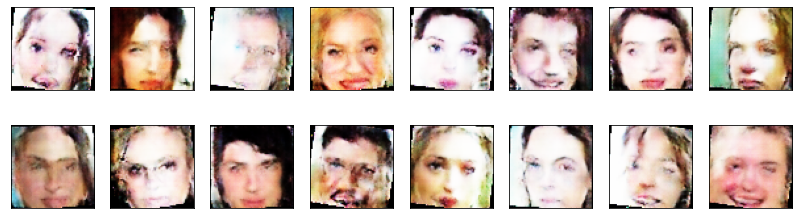

2023-08-07 23:57:43 | Epoch [10/20] | Batch 0/509 | d_loss: 1.2384 | g_loss: 0.7356
2023-08-07 23:57:54 | Epoch [10/20] | Batch 50/509 | d_loss: 1.1750 | g_loss: 1.0024
2023-08-07 23:58:06 | Epoch [10/20] | Batch 100/509 | d_loss: 1.3302 | g_loss: 1.4678
2023-08-07 23:58:17 | Epoch [10/20] | Batch 150/509 | d_loss: 1.5624 | g_loss: 0.4647
2023-08-07 23:58:28 | Epoch [10/20] | Batch 200/509 | d_loss: 1.0646 | g_loss: 0.9206
2023-08-07 23:58:39 | Epoch [10/20] | Batch 250/509 | d_loss: 1.3638 | g_loss: 1.6335
2023-08-07 23:58:50 | Epoch [10/20] | Batch 300/509 | d_loss: 1.1283 | g_loss: 1.1472
2023-08-07 23:59:01 | Epoch [10/20] | Batch 350/509 | d_loss: 1.0807 | g_loss: 0.8682
2023-08-07 23:59:12 | Epoch [10/20] | Batch 400/509 | d_loss: 1.0230 | g_loss: 0.7875
2023-08-07 23:59:24 | Epoch [10/20] | Batch 450/509 | d_loss: 1.1467 | g_loss: 1.6293
2023-08-07 23:59:35 | Epoch [10/20] | Batch 500/509 | d_loss: 0.9275 | g_loss: 0.8224


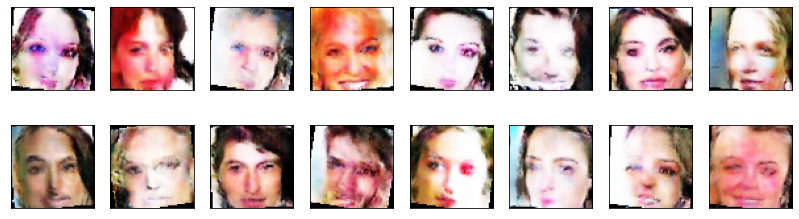

2023-08-07 23:59:41 | Epoch [11/20] | Batch 0/509 | d_loss: 1.0647 | g_loss: 2.4180
2023-08-07 23:59:50 | Epoch [11/20] | Batch 50/509 | d_loss: 1.6680 | g_loss: 3.0662
2023-08-07 23:59:59 | Epoch [11/20] | Batch 100/509 | d_loss: 0.8307 | g_loss: 1.0836
2023-08-08 00:00:08 | Epoch [11/20] | Batch 150/509 | d_loss: 1.1623 | g_loss: 0.7586
2023-08-08 00:00:17 | Epoch [11/20] | Batch 200/509 | d_loss: 0.7630 | g_loss: 1.3710
2023-08-08 00:00:26 | Epoch [11/20] | Batch 250/509 | d_loss: 1.3300 | g_loss: 0.3169
2023-08-08 00:00:35 | Epoch [11/20] | Batch 300/509 | d_loss: 0.9022 | g_loss: 1.2155
2023-08-08 00:00:43 | Epoch [11/20] | Batch 350/509 | d_loss: 0.8975 | g_loss: 3.6717
2023-08-08 00:00:52 | Epoch [11/20] | Batch 400/509 | d_loss: 0.7415 | g_loss: 1.5557
2023-08-08 00:01:01 | Epoch [11/20] | Batch 450/509 | d_loss: 0.5152 | g_loss: 2.2153
2023-08-08 00:01:10 | Epoch [11/20] | Batch 500/509 | d_loss: 0.8017 | g_loss: 0.5317


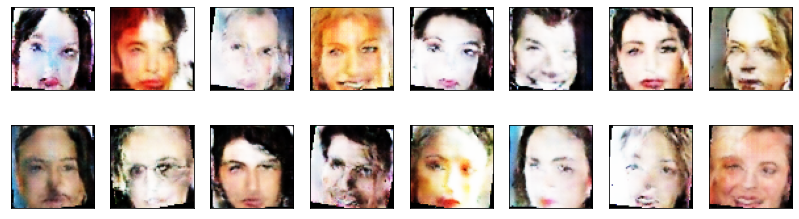

2023-08-08 00:01:16 | Epoch [12/20] | Batch 0/509 | d_loss: 0.4964 | g_loss: 2.2596
2023-08-08 00:01:27 | Epoch [12/20] | Batch 50/509 | d_loss: 0.8689 | g_loss: 0.9558
2023-08-08 00:01:38 | Epoch [12/20] | Batch 100/509 | d_loss: 0.6548 | g_loss: 1.0056
2023-08-08 00:01:49 | Epoch [12/20] | Batch 150/509 | d_loss: 0.6786 | g_loss: 1.4523
2023-08-08 00:02:00 | Epoch [12/20] | Batch 200/509 | d_loss: 0.6896 | g_loss: 1.2818
2023-08-08 00:02:11 | Epoch [12/20] | Batch 250/509 | d_loss: 1.0568 | g_loss: 2.9421
2023-08-08 00:02:23 | Epoch [12/20] | Batch 300/509 | d_loss: 0.9309 | g_loss: 1.4117
2023-08-08 00:02:34 | Epoch [12/20] | Batch 350/509 | d_loss: 0.5957 | g_loss: 1.6130
2023-08-08 00:02:45 | Epoch [12/20] | Batch 400/509 | d_loss: 0.8353 | g_loss: 1.0340
2023-08-08 00:02:56 | Epoch [12/20] | Batch 450/509 | d_loss: 0.6245 | g_loss: 2.0051
2023-08-08 00:03:07 | Epoch [12/20] | Batch 500/509 | d_loss: 0.7713 | g_loss: 0.6761


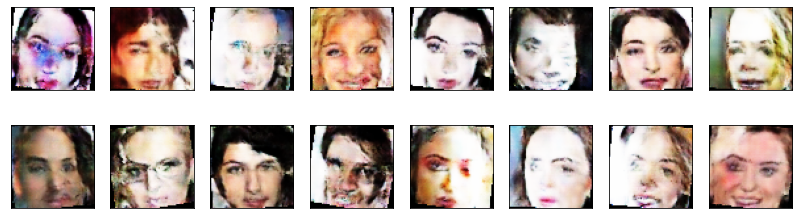

2023-08-08 00:03:14 | Epoch [13/20] | Batch 0/509 | d_loss: 0.6072 | g_loss: 2.2111
2023-08-08 00:03:25 | Epoch [13/20] | Batch 50/509 | d_loss: 1.1421 | g_loss: 3.4207
2023-08-08 00:03:36 | Epoch [13/20] | Batch 100/509 | d_loss: 0.7581 | g_loss: 1.6798
2023-08-08 00:03:47 | Epoch [13/20] | Batch 150/509 | d_loss: 0.5096 | g_loss: 2.0953
2023-08-08 00:03:59 | Epoch [13/20] | Batch 200/509 | d_loss: 0.6638 | g_loss: 1.3482
2023-08-08 00:04:10 | Epoch [13/20] | Batch 250/509 | d_loss: 0.8016 | g_loss: 2.3423
2023-08-08 00:04:21 | Epoch [13/20] | Batch 300/509 | d_loss: 0.7672 | g_loss: 2.6368
2023-08-08 00:04:32 | Epoch [13/20] | Batch 350/509 | d_loss: 0.6426 | g_loss: 1.4614
2023-08-08 00:04:43 | Epoch [13/20] | Batch 400/509 | d_loss: 0.9091 | g_loss: 4.2637
2023-08-08 00:04:54 | Epoch [13/20] | Batch 450/509 | d_loss: 1.2315 | g_loss: 3.3321
2023-08-08 00:05:05 | Epoch [13/20] | Batch 500/509 | d_loss: 1.4639 | g_loss: 0.8152


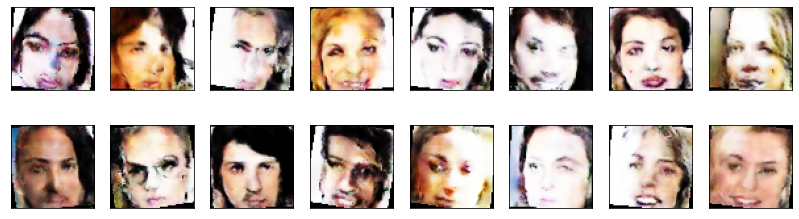

2023-08-08 00:05:11 | Epoch [14/20] | Batch 0/509 | d_loss: 0.7876 | g_loss: 1.3062
2023-08-08 00:05:20 | Epoch [14/20] | Batch 50/509 | d_loss: 0.3630 | g_loss: 1.4622
2023-08-08 00:05:29 | Epoch [14/20] | Batch 100/509 | d_loss: 0.5229 | g_loss: 3.1397
2023-08-08 00:05:38 | Epoch [14/20] | Batch 150/509 | d_loss: 0.3392 | g_loss: 1.3890
2023-08-08 00:05:47 | Epoch [14/20] | Batch 200/509 | d_loss: 0.4852 | g_loss: 1.8840
2023-08-08 00:05:56 | Epoch [14/20] | Batch 250/509 | d_loss: 0.4567 | g_loss: 2.2669
2023-08-08 00:06:04 | Epoch [14/20] | Batch 300/509 | d_loss: 0.4336 | g_loss: 1.4226
2023-08-08 00:06:13 | Epoch [14/20] | Batch 350/509 | d_loss: 0.3370 | g_loss: 1.8153
2023-08-08 00:06:22 | Epoch [14/20] | Batch 400/509 | d_loss: 0.4274 | g_loss: 1.3239
2023-08-08 00:06:31 | Epoch [14/20] | Batch 450/509 | d_loss: 0.2740 | g_loss: 1.7987
2023-08-08 00:06:39 | Epoch [14/20] | Batch 500/509 | d_loss: 0.4507 | g_loss: 1.9869


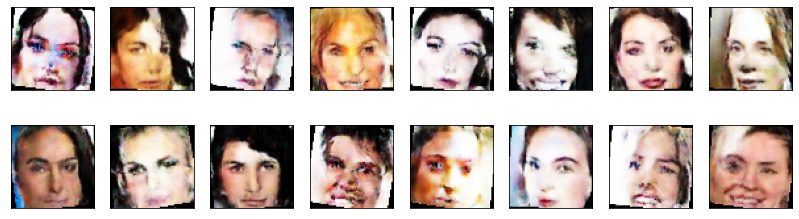

2023-08-08 00:06:45 | Epoch [15/20] | Batch 0/509 | d_loss: 1.0277 | g_loss: 4.6332
2023-08-08 00:06:56 | Epoch [15/20] | Batch 50/509 | d_loss: 0.5130 | g_loss: 2.9070
2023-08-08 00:07:08 | Epoch [15/20] | Batch 100/509 | d_loss: 0.8737 | g_loss: 4.9310
2023-08-08 00:07:19 | Epoch [15/20] | Batch 150/509 | d_loss: 0.6131 | g_loss: 4.1948
2023-08-08 00:07:30 | Epoch [15/20] | Batch 200/509 | d_loss: 0.6383 | g_loss: 3.3429
2023-08-08 00:07:41 | Epoch [15/20] | Batch 250/509 | d_loss: 0.9915 | g_loss: 5.8808
2023-08-08 00:07:53 | Epoch [15/20] | Batch 300/509 | d_loss: 0.5789 | g_loss: 1.4537
2023-08-08 00:08:04 | Epoch [15/20] | Batch 350/509 | d_loss: 0.4247 | g_loss: 1.7276
2023-08-08 00:08:15 | Epoch [15/20] | Batch 400/509 | d_loss: 0.2929 | g_loss: 2.3107
2023-08-08 00:08:26 | Epoch [15/20] | Batch 450/509 | d_loss: 0.5636 | g_loss: 3.5958
2023-08-08 00:08:37 | Epoch [15/20] | Batch 500/509 | d_loss: 0.3279 | g_loss: 2.1032


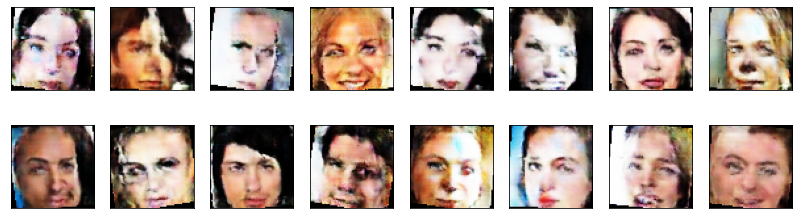

2023-08-08 00:08:43 | Epoch [16/20] | Batch 0/509 | d_loss: 0.5996 | g_loss: 3.2671
2023-08-08 00:08:54 | Epoch [16/20] | Batch 50/509 | d_loss: 0.5817 | g_loss: 3.7577
2023-08-08 00:09:05 | Epoch [16/20] | Batch 100/509 | d_loss: 0.3276 | g_loss: 1.6642
2023-08-08 00:09:16 | Epoch [16/20] | Batch 150/509 | d_loss: 0.6945 | g_loss: 3.2051
2023-08-08 00:09:27 | Epoch [16/20] | Batch 200/509 | d_loss: 0.3748 | g_loss: 2.9225
2023-08-08 00:09:38 | Epoch [16/20] | Batch 250/509 | d_loss: 0.6816 | g_loss: 1.2638
2023-08-08 00:09:49 | Epoch [16/20] | Batch 300/509 | d_loss: 0.5160 | g_loss: 5.0077
2023-08-08 00:10:01 | Epoch [16/20] | Batch 350/509 | d_loss: 0.9438 | g_loss: 5.5962
2023-08-08 00:10:12 | Epoch [16/20] | Batch 400/509 | d_loss: 0.8026 | g_loss: 1.0759
2023-08-08 00:10:23 | Epoch [16/20] | Batch 450/509 | d_loss: 0.4435 | g_loss: 3.2868
2023-08-08 00:10:34 | Epoch [16/20] | Batch 500/509 | d_loss: 0.7026 | g_loss: 4.7854


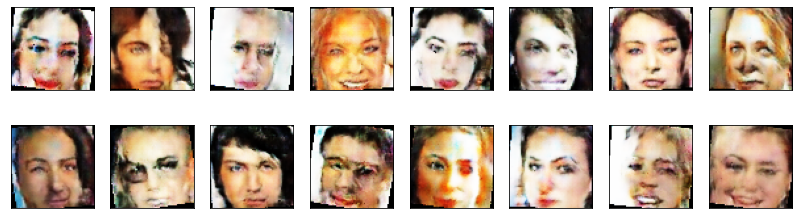

2023-08-08 00:10:39 | Epoch [17/20] | Batch 0/509 | d_loss: 0.3549 | g_loss: 2.8271
2023-08-08 00:10:48 | Epoch [17/20] | Batch 50/509 | d_loss: 0.2049 | g_loss: 3.5574
2023-08-08 00:10:57 | Epoch [17/20] | Batch 100/509 | d_loss: 0.6196 | g_loss: 2.2341
2023-08-08 00:11:06 | Epoch [17/20] | Batch 150/509 | d_loss: 0.3420 | g_loss: 3.8375
2023-08-08 00:11:14 | Epoch [17/20] | Batch 200/509 | d_loss: 0.3399 | g_loss: 3.5834
2023-08-08 00:11:23 | Epoch [17/20] | Batch 250/509 | d_loss: 1.0759 | g_loss: 1.5339
2023-08-08 00:11:32 | Epoch [17/20] | Batch 300/509 | d_loss: 0.4262 | g_loss: 1.6644
2023-08-08 00:11:41 | Epoch [17/20] | Batch 350/509 | d_loss: 0.2828 | g_loss: 1.8765
2023-08-08 00:11:50 | Epoch [17/20] | Batch 400/509 | d_loss: 0.2228 | g_loss: 2.5914
2023-08-08 00:11:59 | Epoch [17/20] | Batch 450/509 | d_loss: 0.2489 | g_loss: 2.6962
2023-08-08 00:12:07 | Epoch [17/20] | Batch 500/509 | d_loss: 0.3201 | g_loss: 2.3515


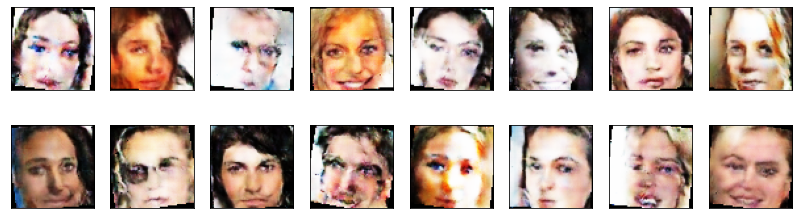

2023-08-08 00:12:13 | Epoch [18/20] | Batch 0/509 | d_loss: 0.2266 | g_loss: 2.2218
2023-08-08 00:12:24 | Epoch [18/20] | Batch 50/509 | d_loss: 0.2840 | g_loss: 1.8813
2023-08-08 00:12:36 | Epoch [18/20] | Batch 100/509 | d_loss: 0.2731 | g_loss: 1.8273
2023-08-08 00:12:47 | Epoch [18/20] | Batch 150/509 | d_loss: 0.5034 | g_loss: 4.0049
2023-08-08 00:12:58 | Epoch [18/20] | Batch 200/509 | d_loss: 0.2573 | g_loss: 1.9206
2023-08-08 00:13:09 | Epoch [18/20] | Batch 250/509 | d_loss: 0.3276 | g_loss: 1.2231
2023-08-08 00:13:20 | Epoch [18/20] | Batch 300/509 | d_loss: 0.3766 | g_loss: 3.0873
2023-08-08 00:13:31 | Epoch [18/20] | Batch 350/509 | d_loss: 0.3936 | g_loss: 3.9799
2023-08-08 00:13:42 | Epoch [18/20] | Batch 400/509 | d_loss: 0.3655 | g_loss: 1.3017
2023-08-08 00:13:53 | Epoch [18/20] | Batch 450/509 | d_loss: 0.3819 | g_loss: 1.3545
2023-08-08 00:14:04 | Epoch [18/20] | Batch 500/509 | d_loss: 0.2863 | g_loss: 2.6095


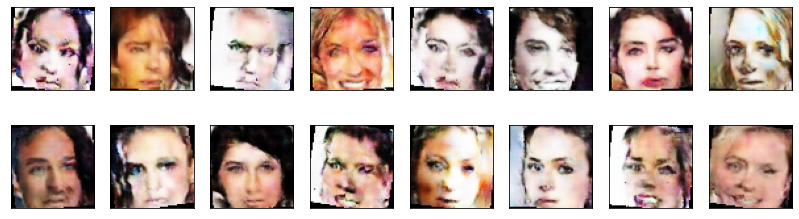

2023-08-08 00:14:11 | Epoch [19/20] | Batch 0/509 | d_loss: 0.4103 | g_loss: 3.3846
2023-08-08 00:14:22 | Epoch [19/20] | Batch 50/509 | d_loss: 0.3931 | g_loss: 1.9140
2023-08-08 00:14:33 | Epoch [19/20] | Batch 100/509 | d_loss: 0.6675 | g_loss: 5.1732
2023-08-08 00:14:45 | Epoch [19/20] | Batch 150/509 | d_loss: 0.2242 | g_loss: 3.4104
2023-08-08 00:14:56 | Epoch [19/20] | Batch 200/509 | d_loss: 0.4250 | g_loss: 2.9974
2023-08-08 00:15:07 | Epoch [19/20] | Batch 250/509 | d_loss: 0.5365 | g_loss: 0.4724
2023-08-08 00:15:18 | Epoch [19/20] | Batch 300/509 | d_loss: 0.1989 | g_loss: 2.9169
2023-08-08 00:15:29 | Epoch [19/20] | Batch 350/509 | d_loss: 0.4163 | g_loss: 4.0345
2023-08-08 00:15:40 | Epoch [19/20] | Batch 400/509 | d_loss: 0.6225 | g_loss: 1.4433
2023-08-08 00:15:51 | Epoch [19/20] | Batch 450/509 | d_loss: 0.7384 | g_loss: 0.4629
2023-08-08 00:16:02 | Epoch [19/20] | Batch 500/509 | d_loss: 0.3272 | g_loss: 3.7594


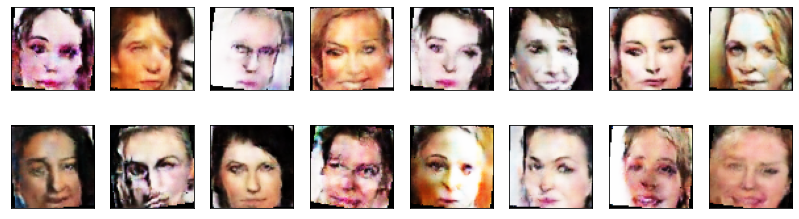

2023-08-08 00:16:08 | Epoch [20/20] | Batch 0/509 | d_loss: 0.3123 | g_loss: 2.1954
2023-08-08 00:16:17 | Epoch [20/20] | Batch 50/509 | d_loss: 0.1679 | g_loss: 3.1901
2023-08-08 00:16:26 | Epoch [20/20] | Batch 100/509 | d_loss: 0.1200 | g_loss: 3.4473
2023-08-08 00:16:35 | Epoch [20/20] | Batch 150/509 | d_loss: 0.1170 | g_loss: 4.2914
2023-08-08 00:16:44 | Epoch [20/20] | Batch 200/509 | d_loss: 0.3765 | g_loss: 6.9376
2023-08-08 00:16:53 | Epoch [20/20] | Batch 250/509 | d_loss: 0.1326 | g_loss: 5.1188
2023-08-08 00:17:02 | Epoch [20/20] | Batch 300/509 | d_loss: 0.1290 | g_loss: 4.1034
2023-08-08 00:17:11 | Epoch [20/20] | Batch 350/509 | d_loss: 0.1547 | g_loss: 4.1671
2023-08-08 00:17:20 | Epoch [20/20] | Batch 400/509 | d_loss: 0.1710 | g_loss: 2.3419
2023-08-08 00:17:29 | Epoch [20/20] | Batch 450/509 | d_loss: 0.2406 | g_loss: 5.7096
2023-08-08 00:17:38 | Epoch [20/20] | Batch 500/509 | d_loss: 0.2166 | g_loss: 4.3619


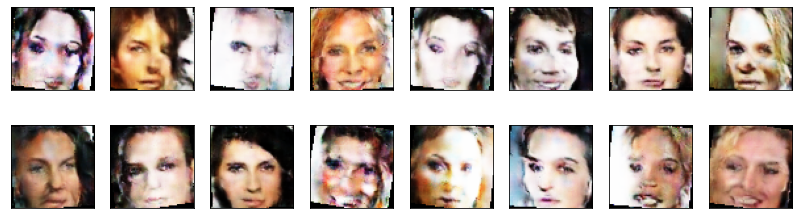

In [25]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)

        ####################################

        # train discriminator
        d_loss = discriminator_step(
            batch_size,
            latent_dim,
            real_images,
            discriminator,
            generator,
            d_optimizer,
        )

        # train generator
        if epoch % 3 == 1:
            n_steps = 2
        else:
            n_steps = 3
        for _ in range(n_steps):
            g_loss = generator_step(
                batch_size, latent_dim, discriminator, generator, g_optimizer
            )

        ####################################

        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss["loss"].item()
            g = g_loss["loss"].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split(".")[0]
            print(
                f"{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}"
            )

    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

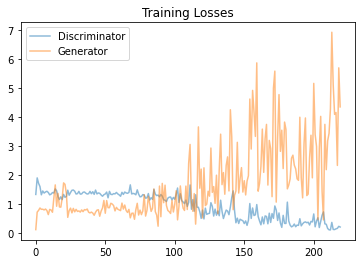

In [26]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label="Discriminator", alpha=0.5)
plt.plot(losses.T[1], label="Generator", alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** The discriminator loss is decreasing with time, but the generator loss is increasing. This is a sign of the discriminator getting better at distinguishing between real and fake images, while the generator is getting worse at fooling the discriminator. Eventually, the generator loss will reach a point where it is no longer able to fool the discriminator and the discriminator loss will reach values close to 0, at which point training should stop. One improvement that could be made to the GAN is to use a different loss function for the generator, such as the Wasserstein loss function. I could also increase the number of time the generator is trained compared to the discriminator, as this would allow the generator to catch up to the discriminator. Regarding the dataset's bias, the generated faces show a high tendency to be white. This could be improved by using a more diverse dataset. The model could also be improved by using a deeper network, as this would allow the model to learn more complex features.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.